In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
import missingno
import dateutil
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

import pandas as pd
import numpy as np
import io #used to read uploaded data
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from math import pi

from sklearn.preprocessing import LabelEncoder


import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
pd.options.mode.chained_assignment = None  # default='warn'

from imblearn.over_sampling import SMOTE

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
import warnings


from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")

## Import Data

In [84]:
train_set = pd.read_csv('train.csv',delimiter =";")
test_set = pd.read_csv('test.csv',delimiter =";")
ids = test_set['claim_id']
test_set = test_set.set_index('claim_id')
train_set = train_set.set_index('claim_id')
train_set.head()

###############################################################
#                     Data cleaning
###############################################################


# number of delay 
train_set['claim_date_registered'] = pd.to_datetime(train_set['claim_date_registered'], format='%Y%m%d')
train_set['claim_date_occured'] = pd.to_datetime(train_set['claim_date_occured'], format='%Y%m%d')

train_set.loc[:,'num_of_delay_days'] = (train_set.loc[:,'claim_date_registered'] - 
                                        train_set.loc[:,'claim_date_occured'])

train_set.loc[:,'num_of_delay_days'] = train_set.loc[:,'num_of_delay_days']//np.timedelta64(1, 'D')

# alcohol_test
train_set['alcohol_test'] = np.where((train_set['claim_alcohol'] =='P')|(train_set['claim_alcohol'] =='N'), 'Yes', 'No')

# age of vehicle (***used reference year as 2017***)
end = 201712.0
train_set.loc[:,'age_of_vehicle'] = (end - train_set.loc[:,'claim_vehicle_date_inuse'])//100

# age of policyholder (***used reference year as 2017***)
reference_year = 2017.0
train_set.loc[:,'age_of_policyholder'] = (reference_year - train_set.loc[:,'policy_holder_year_birth'])

# expert_appointed (Yes -> if there was an expert appointed by the policyholder)
train_set['expert_appointed'] = np.where(train_set['policy_holder_expert_id'].isna(), 'Yes', 'No')

# age of driver (***used reference year as 2017***)
reference_year = 2017.0
train_set.loc[:,'age_of_driver'] = (reference_year - train_set.loc[:,'driver_year_birth'])

# Number of policy years (expiry date - start date)
train_set['policy_date_start'] = pd.to_datetime(train_set['policy_date_start'], format='%Y%m')
train_set['policy_date_next_expiry'] = pd.to_datetime(train_set['policy_date_next_expiry'], format='%Y%m')
train_set.loc[:,'policy_years'] = train_set.loc[:,'policy_date_next_expiry'] - train_set.loc[:,'policy_date_start']
train_set['policy_years'] = round(train_set['policy_years']/np.timedelta64(1, 'Y'),0)

# Renewed? (Missing -> No)
train_set['renewed'] = np.where(train_set['policy_date_last_renewed'].isna(), 'No', 'Yes')

# Repair performed? (Missing -> No)
train_set['repair_performed'] = np.where(train_set['repair_id'].isna(), 'No', 'Yes')

# third party involved?
train_set['tp_claim'] = np.where(train_set['third_party_1_id'].isna(),'N','Y')
# number of third party involved
a = train_set['third_party_1_id'].notna().astype(int)
b = train_set['third_party_2_id'].notna().astype(int)
c = train_set['third_party_3_id'].notna().astype(int)
train_set['n_tp'] = a + b + c 


# number of delay 
test_set['claim_date_registered'] = pd.to_datetime(test_set['claim_date_registered'], format='%Y%m%d')
test_set['claim_date_occured'] = pd.to_datetime(test_set['claim_date_occured'], format='%Y%m%d')
test_set.loc[:,'num_of_delay_days'] = (test_set.loc[:,'claim_date_registered']- test_set.loc[:,'claim_date_occured'])
test_set.loc[:,'num_of_delay_days'] = test_set.loc[:,'num_of_delay_days']//np.timedelta64(1, 'D')

# alcohol_test
test_set['alcohol_test'] = np.where((test_set['claim_alcohol'] =='P')|(test_set['claim_alcohol'] =='N'), 'Yes', 'No')

# age of vehicle (***used reference year as 2018***)
end = 201812.0
test_set.loc[:,'age_of_vehicle'] = (end - test_set.loc[:,'claim_vehicle_date_inuse'])//100

# age of policyholder (***used reference year as 2018***)
reference_year = 2018.0
test_set.loc[:,'age_of_policyholder'] = (reference_year - test_set.loc[:,'policy_holder_year_birth'])

# expert_appointed (Yes -> if there was an expert appointed by the policyholder)
test_set['expert_appointed'] = np.where(test_set['policy_holder_expert_id'].isna(), 'Yes', 'No')

# age of driver (***used reference year as 2018***)
reference_year = 2018.0
test_set.loc[:,'age_of_driver'] = (reference_year - test_set.loc[:,'driver_year_birth'])

# Number of policy years (expiry date - start date)
test_set['policy_date_start'] = pd.to_datetime(test_set['policy_date_start'], format='%Y%m')
test_set['policy_date_next_expiry'] = pd.to_datetime(test_set['policy_date_next_expiry'], format='%Y%m')
test_set.loc[:,'policy_years'] = test_set.loc[:,'policy_date_next_expiry'] - test_set.loc[:,'policy_date_start']
test_set['policy_years'] = round(test_set['policy_years']/np.timedelta64(1, 'Y'),0)

# Renewed? (Missing -> No)
test_set['renewed'] = np.where(test_set['policy_date_last_renewed'].isna(), 'No', 'Yes')

# Repair performed? (Missing -> No)
test_set['repair_performed'] = np.where(test_set['repair_id'].isna(), 'No', 'Yes')

# third party involved?
test_set['tp_claim'] = np.where(test_set['third_party_1_id'].isna(),'N','Y')
# number of third party involved
a = test_set['third_party_1_id'].notna().astype(int)
b = test_set['third_party_2_id'].notna().astype(int)
c = test_set['third_party_3_id'].notna().astype(int)
test_set['n_tp'] = a + b + c 



############################################
#          Missing Values                  #
############################################

train_set['claim_alcohol'].fillna('NA',inplace = True)
train_set['claim_language'].fillna('NA',inplace = True)
train_set['claim_vehicle_type'].fillna('NA',inplace = True)
train_set['claim_vehicle_brand'].fillna('others',inplace = True)
train_set['claim_vehicle_fuel_type'].fillna('NA',inplace = True)
train_set['policy_years'].fillna(0,inplace = True)

# Replacing missing values of claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power with mean based on type 
train_set["claim_vehicle_cyl"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_cyl'].apply(lambda x: x.fillna(x.mean()))
train_set["claim_vehicle_load"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_load'].apply(lambda x: x.fillna(x.mean()))
train_set["claim_vehicle_power"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_power'].apply(lambda x: x.fillna(x.mean()))

# Replace the age of policyholder by mean (as there are no outliers)
train_set['age_of_policyholder'].fillna(train_set['age_of_policyholder'].mean(),inplace = True)

# Replace the policyholder postal code by mode (we can also delete the rows - only 111 - 0.13%)
train_set['policy_holder_postal_code'].fillna(int(train_set['policy_holder_postal_code'].mode()),inplace = True)

# Replace the driver postal code by mode (we can also delete the rows - only 73 - 0.08%)
train_set['driver_postal_code'].fillna(int(train_set['driver_postal_code'].mode()),inplace = True)

# Replace the age of driver by mean (as there are no outliers)
train_set['age_of_driver'].fillna(train_set['age_of_driver'].mean(),inplace = True)

# Replace policy_premium_100 with mean (no outliers)
train_set['policy_premium_100'].fillna(train_set['policy_premium_100'].mean(),inplace = True)

# Replace policy_coverage_1000 with median (there were outliers)
train_set['policy_coverage_1000'].fillna(train_set['policy_coverage_1000'].median(),inplace = True)

# Replace age_of_vehicle with median (there were outliers)
train_set['age_of_vehicle'].fillna(train_set['age_of_vehicle'].median(),inplace = True)



test_set['claim_alcohol'].fillna('NA',inplace = True)
test_set['claim_language'].fillna('NA',inplace = True)
test_set['claim_vehicle_type'].fillna('NA',inplace = True)
test_set['claim_vehicle_brand'].fillna('others',inplace = True)
test_set['claim_vehicle_fuel_type'].fillna('NA',inplace = True)
test_set['policy_years'].fillna(0,inplace = True)

# Replacing missing values of claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power with mean based on type 
test_set["claim_vehicle_cyl"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_cyl'].apply(lambda x: x.fillna(x.mean()))
test_set["claim_vehicle_load"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_load'].apply(lambda x: x.fillna(x.mean()))
test_set["claim_vehicle_power"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_power'].apply(lambda x: x.fillna(x.mean()))

# Replace the age of policyholder by mean (as there are no outliers)
test_set['age_of_policyholder'].fillna(test_set['age_of_policyholder'].mean(),inplace = True)

# Replace the policyholder postal code by mode (we can also delete the rows - only 111 - 0.13%)
test_set['policy_holder_postal_code'].fillna(int(test_set['policy_holder_postal_code'].mode()),inplace = True)

# Replace the driver postal code by mode (we can also delete the rows - only 73 - 0.08%)
test_set['driver_postal_code'].fillna(int(test_set['driver_postal_code'].mode()),inplace = True)

# Replace the age of driver by mean (as there are no outliers)
test_set['age_of_driver'].fillna(test_set['age_of_driver'].mean(),inplace = True)

# Replace policy_premium_100 with mean (no outliers)
test_set['policy_premium_100'].fillna(test_set['policy_premium_100'].mean(),inplace = True)

# Replace policy_coverage_1000 with median (there were outliers)
test_set['policy_coverage_1000'].fillna(test_set['policy_coverage_1000'].median(),inplace = True)

# Replace age_of_vehicle with median (there were outliers)
test_set['age_of_vehicle'].fillna(test_set['age_of_vehicle'].median(),inplace = True)


##################################
# Deleting columns               #
##################################


# deleting columns --> claim_time_occurred(59% of the data missing)

#columns_to_drop = ['claim_time_occured','claim_vehicle_date_inuse','policy_holder_expert_id','policy_holder_year_birth','driver_expert_id',
#                   'driver_year_birth','driver_vehicle_id','third_party_1_id','third_party_1_form','third_party_1_country',
#                   'third_party_1_vehicle_id','third_party_1_expert_id','third_party_2_id','third_party_2_country','third_party_2_form',
#                   'third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id','third_party_3_form','third_party_3_country',
#                   'third_party_3_vehicle_id','third_party_3_expert_id','policy_date_start','policy_date_next_expiry','policy_date_last_renewed',
#                   'repair_id','repair_postal_code','repair_form','repair_year_birth','repair_country','third_party_1_postal_code','third_party_1_injured','third_party_1_vehicle_type','third_party_1_year_birth','third_party_2_postal_code',
#                   'third_party_2_injured','third_party_2_vehicle_type','third_party_2_year_birth','third_party_3_postal_code',
#                   'third_party_3_injured','third_party_3_vehicle_type','third_party_3_year_birth'
                   #,'policy_holder_id','driver_id'
#                  ]
#train_set = train_set.drop(columns = columns_to_drop, axis = 1)


# deleting columns
#columns_to_drop = ['claim_time_occured','claim_vehicle_date_inuse','policy_holder_expert_id','policy_holder_year_birth','driver_expert_id',
#                   'driver_year_birth','driver_vehicle_id','third_party_1_id','third_party_1_form','third_party_1_country',
#                   'third_party_1_vehicle_id','third_party_1_expert_id','third_party_2_id','third_party_2_country','third_party_2_form',
#                   'third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id','third_party_3_form','third_party_3_country',
#                   'third_party_3_vehicle_id','third_party_3_expert_id','policy_date_start','policy_date_next_expiry','policy_date_last_renewed',
#                   'repair_id','repair_postal_code','repair_form','repair_year_birth','repair_country','third_party_1_postal_code','third_party_1_injured','third_party_1_vehicle_type','third_party_1_year_birth','third_party_2_postal_code',
#                   'third_party_2_injured','third_party_2_vehicle_type','third_party_2_year_birth','third_party_3_postal_code',
#                   'third_party_3_injured','third_party_3_vehicle_type','third_party_3_year_birth'
                   #'policy_holder_id','driver_id'
#                  ]
#test_set = test_set.drop(columns = columns_to_drop,axis =1)


# drop when more than 50%

columns_to_drop = ['claim_time_occured','claim_alcohol','policy_holder_expert_id','third_party_1_year_birth',
                   'third_party_1_expert_id','third_party_2_id','third_party_2_postal_code','third_party_2_injured',
                   'third_party_2_vehicle_type','third_party_2_form','third_party_2_year_birth',
                   'third_party_2_country','third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id',
                   'third_party_3_postal_code','third_party_3_injured','third_party_3_vehicle_type',
                   'third_party_3_form','third_party_3_year_birth','third_party_3_country','third_party_3_vehicle_id',
                   'third_party_3_expert_id','repair_year_birth']

train_set = train_set.drop(columns = columns_to_drop, axis = 1)

test_set = test_set.drop(columns = columns_to_drop,axis =1)



#################################
#     Outliers                #
################################


# remove outliers
train_set = train_set.loc[train_set['age_of_vehicle'] > 0]
train_set = train_set.loc[train_set['age_of_policyholder']<90]
train_set = train_set.loc[train_set['age_of_driver']<90]
# claim amount datatype from string to float
train_set['claim_amount'] = train_set['claim_amount'].str.replace("'","")
train_set['claim_amount'] = train_set['claim_amount'].str.replace(",",".")
train_set['claim_amount'] = train_set['claim_amount'].astype(float)
# fraud code to 1 and 0
train_set['fraud'] = train_set['fraud'].map({'Y':1,'N':0})
# converting date variables to string
train_set['claim_date_registered'] = train_set['claim_date_registered'].astype(str)
train_set['claim_date_occured'] = train_set['claim_date_occured'].astype(str)
train_set['claim_postal_code'] = train_set['claim_postal_code'].astype(str)
train_set['policy_holder_postal_code'] = train_set['policy_holder_postal_code'].astype(str)
train_set['driver_postal_code'] = train_set['driver_postal_code'].astype(str)
train_set['claim_language'] = train_set['claim_language'].astype(str)
train_set['claim_vehicle_fuel_type'] = train_set['claim_vehicle_fuel_type'].astype(str)
train_set['claim_vehicle_id'] = train_set['claim_vehicle_id'].astype(str)
train_set['policy_date_start'] = train_set['policy_date_start'].astype(str)
train_set['policy_date_next_expiry'] = train_set['policy_date_next_expiry'].astype(str)



# converting date variables to string
test_set['claim_date_registered'] = test_set['claim_date_registered'].astype(str)
test_set['claim_date_occured'] = test_set['claim_date_occured'].astype(str)
test_set['claim_postal_code'] = test_set['claim_postal_code'].astype(str)
test_set['policy_holder_postal_code'] = test_set['policy_holder_postal_code'].astype(str)
test_set['driver_postal_code'] = test_set['driver_postal_code'].astype(str)
test_set['claim_language'] = test_set['claim_language'].astype(str)
test_set['claim_vehicle_fuel_type'] = test_set['claim_vehicle_fuel_type'].astype(str)
test_set['claim_vehicle_id'] = test_set['claim_vehicle_id'].astype(str)
test_set['policy_date_start'] = test_set['policy_date_start'].astype(str)
test_set['policy_date_next_expiry'] = test_set['policy_date_next_expiry'].astype(str)

dataset_train = train_set.copy()

## Label encode

In [85]:
dataset_train = dataset_train.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

In [86]:
col_names_train = dataset_train.columns.values.tolist()
col_names_test = test_set.columns.values.tolist()

In [87]:
test_set = test_set.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

## KNN impute missing values

In [5]:
from sklearn.impute import KNNImputer

In [88]:
imputer = KNNImputer(n_neighbors = 2)
dataset_train = imputer.fit_transform(dataset_train)

In [89]:
dataset_train = pd.DataFrame(dataset_train)
dataset_train.columns = col_names_train

In [90]:
test_set = imputer.fit_transform(test_set)
test_set = pd.DataFrame(test_set)
test_set.columns = col_names_test

## Split data

In [212]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

# Default Light GBM

In [211]:
train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)

In [323]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    #'num_leaves': 44,
    #'feature_fraction': 0.1,
    #'bagging_fraction': 0.7,
    #'bagging_freq': 1,
    #'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    #'min_child_weight': 5,
    #'max_depth': 5,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

y_pred = model.predict(xtest, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, ytest)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, y_pred)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.732795
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.743279
[3]	valid_0's auc: 0.746706
[4]	valid_0's auc: 0.741305
[5]	valid_0's auc: 0.746804
[6]	valid_0's auc: 0.752623
[7]	valid_0's auc: 0.74965
[8]	valid_0's auc: 0.741823
[9]	valid_0's auc: 0.755767
[10]	valid_0's auc: 0.76642
[11]	valid_0's auc: 0.773224
[12]	valid_0's auc: 0.766841
[13]	valid_0's auc: 0.759306
[

<AxesSubplot:>

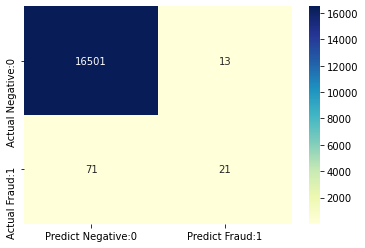

In [324]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Fraud:1'], 
                                 index=['Actual Negative:0', 'Actual Fraud:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


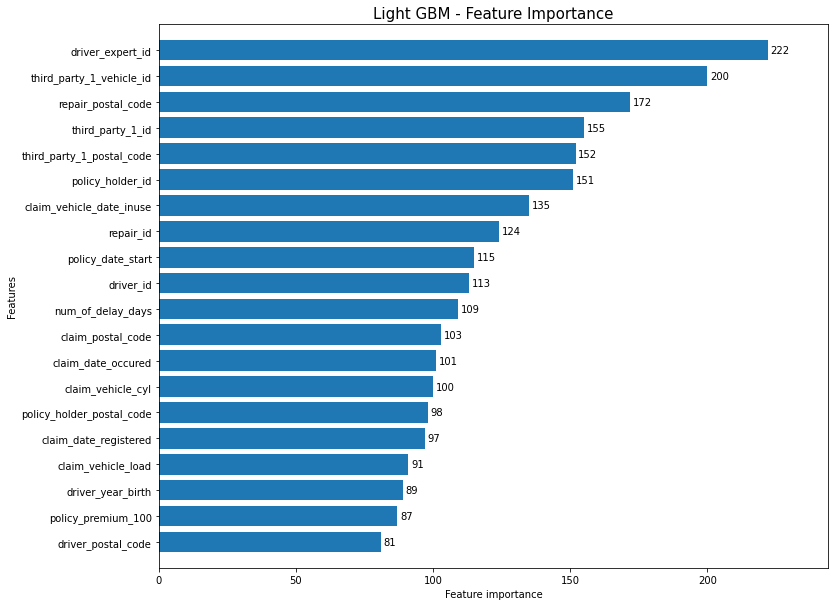

In [325]:
fig,ax = plt.subplots(figsize = (12,10))
lgb.plot_importance(model,max_num_features = 20,height = 0.8,ax = ax)
ax.grid(False)
plt.title("Light GBM - Feature Importance", fontsize = 15)
plt.show()

In [34]:
#from sklearn.feature_selection import RFE
#model = LGBMClassifier()
#model.fit(xtrain,ytrain)
#yhat = model.predict(xtest)
#selector = RFE(clf, n_features_to_select=5, step=1)
#selector = selector.fit(xtrain, ytrain)
#selector.ranking_

In [35]:
#for i in range(xtrain.shape[1]):
#    print('Column: %d, Selected %s, Rank: %.3f' % (i, selector.support_[i], selector.ranking_[i]))

# Default LightGBM ROC Curve

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


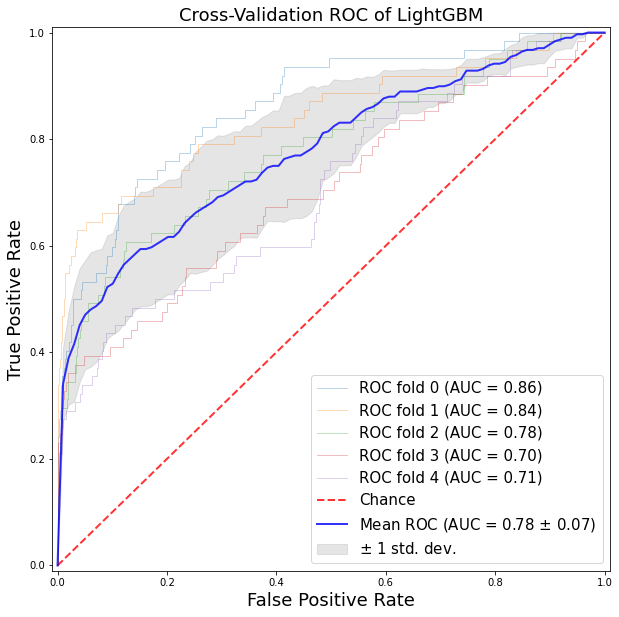

In [326]:
cv = StratifiedKFold(n_splits=5,shuffle=False)

clf = LGBMClassifier(application= 'binary',
    objective = 'binary',
    #max_bin = 255,
    metric = 'auc',
    #'is_unbalance'= 'true',
    boosting= 'gbdt',
    #num_leaves= 44,
    #'feature_fraction'= 0.1,
    #'bagging_fraction'= 0.7,
    #bagging_freq = 1,
    #learning_rate = 0.01,
    #min_data_in_leaf = 100,
    #min_child_weight = 5,
    #max_depth= 6,
    #num_boost_round=5000
    #verbose = 0
    )



x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(x, y):
    probas_ = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LightGBM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=5,shuffle=False)

clf = LGBMClassifier(application= 'binary',
    objective = 'binary',
    #max_bin = 255,
    metric = 'auc',
    #'is_unbalance'= 'true',
    boosting= 'gbdt',
    #num_leaves= 44,
    #'feature_fraction'= 0.1,
    #'bagging_fraction'= 0.7,
    #bagging_freq = 1,
    #learning_rate = 0.01,
    #min_data_in_leaf = 100,
    #min_child_weight = 5,
    #max_depth= 6,
    #num_boost_round=5000
    #verbose = 0
    )



x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(train_data, y):
    probas_ = model.train(train_data).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LightGBM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# Precision- Recall

Logistic: f1=0.333 auc=0.288


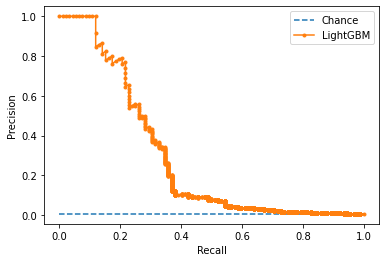

In [327]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

lr_probs = model.predict(xtest,num_iteration=model.best_iteration)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# predict class values
yhat = [1 if x >= 0.5 else 0 for x in lr_probs]
yhat = [np.min(x) for x in yhat]
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# SMOTE

In [328]:
train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)

In [337]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']

smote = SMOTE(random_state=123)
X_smote, y_smote = smote.fit_resample(X, Y)
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X_smote,y_smote,test_size = 0.30,stratify = y_smote,random_state=100)

train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)


parameters = {
    'application': 'binary',
    'objective': 'binary',
    'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 44,
    #'feature_fraction': 0.1,
    'bagging_fraction': 0.9,
    #'bagging_freq': 1,
    #'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    #'min_child_weight': 5,
    #'max_depth': 6,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.988407
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.990607
[3]	valid_0's auc: 0.99511
[4]	valid_0's auc: 0.995629
[5]	valid_0's auc: 0.995763
[6]	valid_0's auc: 0.995651
[7]	valid_0's auc: 0.996435
[8]	valid_0's auc: 0.996338
[9]	valid_0's auc: 0.996548
[10]	valid_0's auc: 0.996724
[11]	valid_0's auc: 0.996712
[12]	valid_0's auc: 0.996879
[13]	valid_0's auc: 0.996953


[258]	valid_0's auc: 0.999752
[259]	valid_0's auc: 0.999752
[260]	valid_0's auc: 0.999752
[261]	valid_0's auc: 0.999753
[262]	valid_0's auc: 0.999753
[263]	valid_0's auc: 0.999752
[264]	valid_0's auc: 0.999755
[265]	valid_0's auc: 0.999755
[266]	valid_0's auc: 0.999753
[267]	valid_0's auc: 0.999752
[268]	valid_0's auc: 0.999752
[269]	valid_0's auc: 0.999752
[270]	valid_0's auc: 0.999751
[271]	valid_0's auc: 0.999752
[272]	valid_0's auc: 0.999751
[273]	valid_0's auc: 0.99975
[274]	valid_0's auc: 0.999749
[275]	valid_0's auc: 0.999751
[276]	valid_0's auc: 0.999749
[277]	valid_0's auc: 0.99975
[278]	valid_0's auc: 0.999748
[279]	valid_0's auc: 0.999752
[280]	valid_0's auc: 0.999752
[281]	valid_0's auc: 0.999752
[282]	valid_0's auc: 0.999751
[283]	valid_0's auc: 0.999754
[284]	valid_0's auc: 0.999755
[285]	valid_0's auc: 0.999753
[286]	valid_0's auc: 0.999755
[287]	valid_0's auc: 0.999756
[288]	valid_0's auc: 0.999756
[289]	valid_0's auc: 0.999755
[290]	valid_0's auc: 0.999758
[291]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's auc: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's auc: 0.999796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's auc: 0.999796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's auc: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's auc: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's auc: 0.999798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's auc: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's auc: 0.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's auc: 0.999801
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's auc: 0.999814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's auc: 0.999815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.999815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's auc: 0.999815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	valid_0's auc: 0.999814
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain,

[658]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's auc: 0.999821
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive ga

[828]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[834]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[835]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[836]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[837]	valid_0's auc: 0.999823
[LightGBM] [Warning] No f

In [338]:
y_pred = model.predict(xtest, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16508     6]
 [   71 16442]]

True Positives(TP) =  16508

True Negatives(TN) =  16442

False Positives(FP) =  6

False Negatives(FN) =  71


<AxesSubplot:>

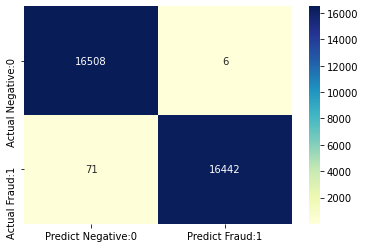

In [339]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Fraud:1'], 
                                 index=['Actual Negative:0', 'Actual Fraud:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [102]:
ytest.sum()

92.0

In [340]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']

# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

y_pred = model.predict(xtest)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16508     6]
 [   23    69]]

True Positives(TP) =  16508

True Negatives(TN) =  69

False Positives(FP) =  6

False Negatives(FN) =  23


<AxesSubplot:>

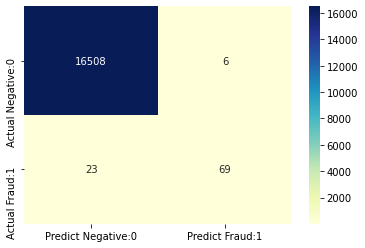

In [333]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Fraud:1'], 
                                 index=['Actual Negative:0', 'Actual Fraud:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Bayesian Tuning

In [218]:
x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']

smote = SMOTE(random_state=123)
x, y = smote.fit_resample(x, y)

def bayes_parameter_opt_lgb(x, y, init_round=100, opt_round=100, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.01, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=x, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'binary_logloss'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        #params['min_split_gain'] = min_split_gain
        #params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3)},
                                            #'min_split_gain': (0.001, 0.1),
                                            #'min_child_weight': (5, 50)}, 
                                             random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO
    print(lgbBO.max['params'])
    print(lgbBO.res)
    

opt_params = bayes_parameter_opt_lgb(x, y, init_round=10, opt_round=10, n_folds=5, random_seed=6, n_estimators=100, learning_rate=0.1)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 44035, number of negative: 44035
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88070, number of used features: 62
[LightGBM] [Info] Number of positive: 44035, number of negative: 44035
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88070, number of used features: 62
[LightGBM] [Info] Number of positive: 44035, number of negative: 44035
[Ligh

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000023
[LightGBM] [Info] Start training from score 0.000023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499994 -> initscore=-0.000023
[LightGBM] [Info] Start training from score -0.000023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 44036, number of negative: 44035
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Info] Number of positive: 44035, number of negative: 44036
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88070, number of used features: 62
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 44036, number of negative: 44035
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

[LightGBM] [Info] Number of positive: 44036, number of negative: 44035
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Info] Number of positive: 44035, number of negative: 44036
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15503
[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

[LightGBM] [Info] Number of data points in the train set: 88071, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000023
[LightGBM] [Info] Start training from score 0.000023
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499994 -> initscore=-0.000023
[LightGBM] [Info] Start training from score -0.000023
|  18       |  0.9997   |  0.9396   |  0.4781   |  0.907    |  2.912    |  8.941    |  37.81    |
[LightGBM] [Info] Number of positive: 44035, number of negative: 44035
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

In [166]:
params = opt_params.max['params']
params

{'bagging_fraction': 1.0,
 'feature_fraction': 0.9,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'max_depth': 8.99,
 'num_leaves': 40.35835667715903}

In [ ]:
{'bagging_fraction': 1.0,
 'feature_fraction': 0.9,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'max_depth': 8.99,
 'num_leaves': 40.35835667715903}

parameters log loss binary

In [219]:
params = opt_params.max['params']
params

{'bagging_fraction': 0.9396401495858502,
 'feature_fraction': 0.4781183283884184,
 'lambda_l1': 0.9070137127813516,
 'lambda_l2': 2.912059806440209,
 'max_depth': 8.940979336669429,
 'num_leaves': 37.808655112597435}

# Tuned SMOTE 

In [299]:
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']

smote = SMOTE(random_state=123)
X_smote, y_smote = smote.fit_resample(X, Y)
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X_smote,y_smote,test_size = 0.30,stratify = y_smote,random_state=100)

train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)


parameters = {
    'application': 'binary',
    'objective': 'binary',
    #'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 44,
    #'feature_fraction': 0.5,
    #'bagging_fraction': 1,
    #'bagging_freq': 1,
    #'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    #'min_child_weight': 5,
    #'lambda_l1': 1,
    #'lambda_l2': 3,
    #'max_depth': 9,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.988407
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.990607
[3]	valid_0's auc: 0.99511
[4]	valid_0's auc: 0.995629
[5]	valid_0's auc: 0.995763
[6]	valid_0's auc: 0.995651
[7]	valid_0's auc: 0.996435
[8]	valid_0's auc: 0.996338
[9]	valid_0's auc: 0.996548
[10]	valid_0's auc: 0.996724
[11]	valid_0's auc: 0.996712
[12]	valid_0's auc: 0.996879
[13]	valid_0's auc: 0.996953


[260]	valid_0's auc: 0.999752
[261]	valid_0's auc: 0.999753
[262]	valid_0's auc: 0.999753
[263]	valid_0's auc: 0.999752
[264]	valid_0's auc: 0.999755
[265]	valid_0's auc: 0.999755
[266]	valid_0's auc: 0.999753
[267]	valid_0's auc: 0.999752
[268]	valid_0's auc: 0.999752
[269]	valid_0's auc: 0.999752
[270]	valid_0's auc: 0.999751
[271]	valid_0's auc: 0.999752
[272]	valid_0's auc: 0.999751
[273]	valid_0's auc: 0.99975
[274]	valid_0's auc: 0.999749
[275]	valid_0's auc: 0.999751
[276]	valid_0's auc: 0.999749
[277]	valid_0's auc: 0.99975
[278]	valid_0's auc: 0.999748
[279]	valid_0's auc: 0.999752
[280]	valid_0's auc: 0.999752
[281]	valid_0's auc: 0.999752
[282]	valid_0's auc: 0.999751
[283]	valid_0's auc: 0.999754
[284]	valid_0's auc: 0.999755
[285]	valid_0's auc: 0.999753
[286]	valid_0's auc: 0.999755
[287]	valid_0's auc: 0.999756
[288]	valid_0's auc: 0.999756
[289]	valid_0's auc: 0.999755
[290]	valid_0's auc: 0.999758
[291]	valid_0's auc: 0.99976
[292]	valid_0's auc: 0.999759
[293]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's auc: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's auc: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's auc: 0.999798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's auc: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's auc: 0.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's auc: 0.999801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's auc: 0.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's auc: 0.999801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's auc: 0.999802
[LightGBM] [Warning] No further splits with positive gain, 

[490]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's auc: 0.999812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's auc: 0.999813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's auc: 0.999814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's auc: 0.999815
[LightGBM] [Warning] No f

[574]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[579]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's auc: 0.999819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	valid_0's auc: 0.999819
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's auc: 0.99982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's auc: 0.999821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's auc: 0.999822
[LightGBM] [Warning] No further splits with positive ga

In [300]:
y_pred = model.predict(xtest, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16508     6]
 [   71 16442]]

True Positives(TP) =  16508

True Negatives(TN) =  16442

False Positives(FP) =  6

False Negatives(FN) =  71


<AxesSubplot:>

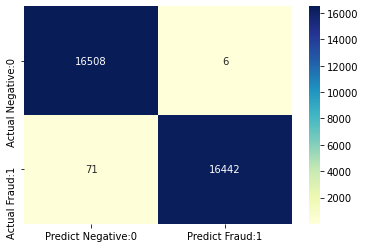

In [301]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Fraud:1'], 
                                 index=['Actual Negative:0', 'Actual Fraud:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [307]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']

# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

y_pred = model.predict(xtest)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16508     6]
 [   23    69]]

True Positives(TP) =  16508

True Negatives(TN) =  69

False Positives(FP) =  6

False Negatives(FN) =  23


## Recal after Smote

Logistic: f1=0.826 auc=0.840


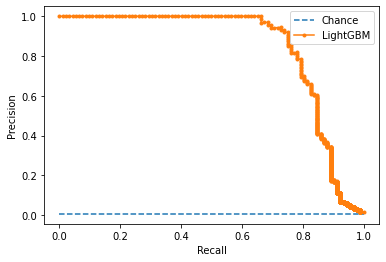

In [334]:
# split trainset
#X = dataset_train.drop('fraud',axis = 1)
#X = X.drop('claim_amount', axis=1)
#Y = dataset_train['fraud']
# split into train and validation set
#xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

lr_probs = model.predict(xtest,num_iteration=model.best_iteration)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# predict class values
yhat = [1 if x >= 0.5 else 0 for x in lr_probs]
yhat = [np.min(x) for x in yhat]
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Lets do this!

In [356]:
param = {
    'objective': 'binary',
    'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 44,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 1,
    #'bagging_freq': 1,
    #'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    #'min_child_weight': 5,
    #'lambda_l1': 0,
    #'lambda_l2': 0,
    #'max_depth': 0,
    'verbose': -1
}




train = dataset_train.drop('fraud',axis = 1)
train = train.drop('claim_amount', axis=1)
target = dataset_train['fraud']

#smote = SMOTE(random_state=123)
#train, target = smote.fit_resample(train, target)

num_folds = 5
features = [c for c in train.columns if c not in ['claim_amount', 'fraud']]

folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(test_set))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_set, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 1	valid_1's auc: 0.835864
[10000]	training's auc: 1	valid_1's auc: 0.837626
[15000]	training's auc: 1	valid_1's auc: 0.838197
[20000]	training's auc: 1	valid_1's auc: 0.838757
[25000]	training's auc: 1	valid_1's auc: 0.83912


KeyboardInterrupt: 

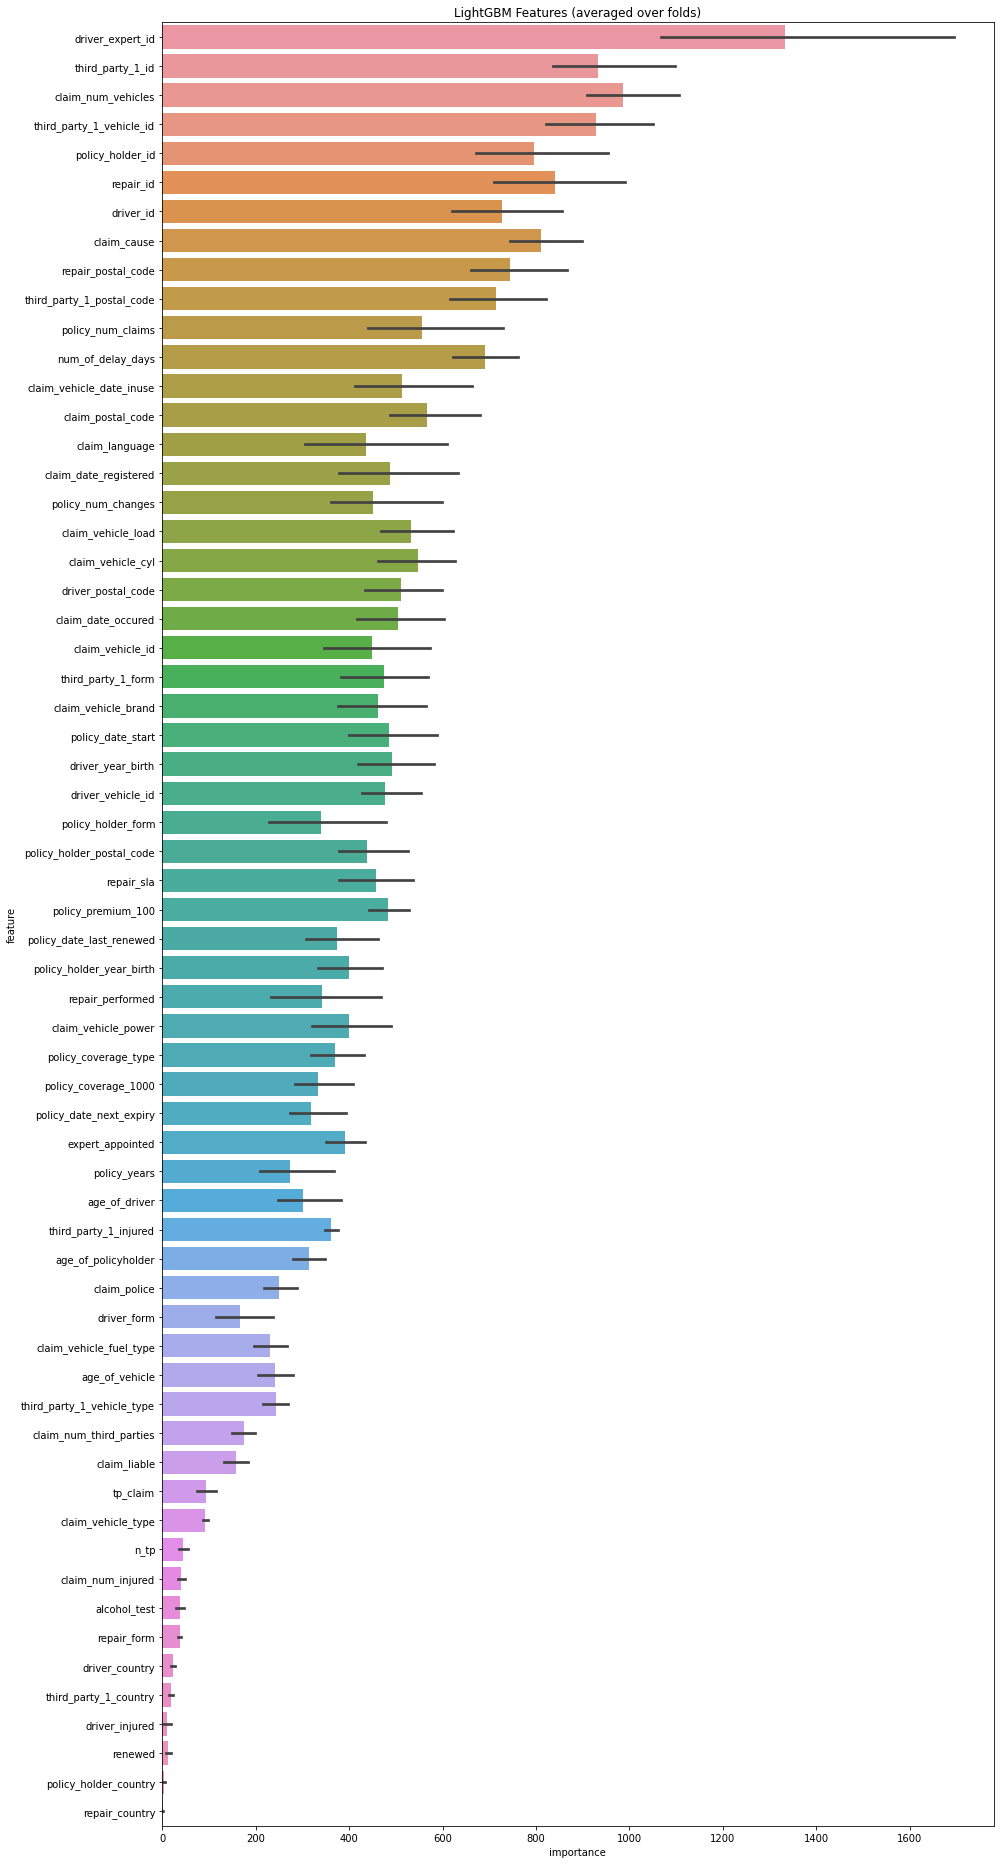

In [344]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

# close to end

In [335]:
y_pred_prob = model.predict(test_set,num_iteration=model.best_iteration)
best_valid_preds = [np.min(x) for x in y_pred_prob]
best_valid_preds = pd.DataFrame(best_valid_preds)
best_valid_preds['claimID'] = ids
best_valid_preds.columns = ['Prob', 'claim_id']
best_valid_preds = best_valid_preds[['claim_id', 'Prob']]
#best_valid_preds.to_csv('imdone.csv', encoding='utf-8', index=False, header = False)
best_valid_preds

,claim_id,Prob
0,65469,7.087883e-11
1,65470,3.899752e-10
2,65471,1.608789e-09
3,65472,8.210444e-11
4,65473,2.043735e-10
...,...,...
29950,95422,1.202443e-04
29951,95423,2.430807e-03
29952,95424,5.791752e-07
29953,95425,3.710550e-08


In [354]:
(best_valid_preds['Prob'] > 0.5).sum()

36

In [355]:
y_pred_prob = predictions
best_valid_preds = [np.min(x) for x in y_pred_prob]
best_valid_preds = pd.DataFrame(best_valid_preds)
best_valid_preds['claimID'] = ids
best_valid_preds.columns = ['Prob', 'claim_id']
best_valid_preds = best_valid_preds[['claim_id', 'Prob']]
best_valid_preds.to_csv('lastdayattempt.csv', encoding='utf-8', index=False, header = False)
best_valid_preds

,claim_id,Prob
0,65469,1.906498e-10
1,65470,2.233595e-09
2,65471,2.155837e-09
3,65472,4.335260e-09
4,65473,4.900362e-11
...,...,...
29950,95422,2.488670e-04
29951,95423,4.638954e-03
29952,95424,1.129203e-06
29953,95425,7.407625e-08


# END!!!!!!!!!!!!!1